In [ ]:
%matplotlib inline

# FRAGMENTATION INDEX COMPUTATION 

**Author**: Luigi Gisolfi

**Year**: 2023

This code computes the (Upgraded) Fragmentation Environmental Index, as devised in [L. Gisolfi Master's Thesis](https://thesis.unipd.it/retrieve/b00fb71a-4118-444b-bb0e-3ab77846ce05/Gisolfi_Luigi.pdf.pdf). 

Please, create the folder nube_XXX_km with the all the files cloud_XXX.fla 
Also, create the empty folders: weights, figures, CSI_out (containing CSI0.out) INSIDE the folder named nube_XXX_km before running this code.
Make sure you have access to the file dens_mean_no_weights_2023.dat
Note: For the background, only MASTER population objects > 5 cm is considered (file: background_pop.dat.5cm) has to be used as input


## Import Statements
Let's start by importing some relevant python modules that will be useful for the computation.

In [5]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os
import math
import time

# Auxiliary Functions - A library
In what follows, we define some functions that we will need for
* the computation of both radar and optical weights to be applied to the Criticality of Spacecraft Index (CSI)
* the computation of the CSI

## Radar Range equation
The observable given by a Resident Space Object is often given in terms of **range**, but the CSI definition rather relies on its **altitude**. The functions _h_to_rho_ and *rho_to_h* allow the user to go back and forth between the two quantities. 

An object of the Earth's surface (with radius $r_{e} = 6378$ km) has an altitude of $0$ km.

In [ ]:
r_e = 6378 #in km

def rho_to_h(rho): #rho = target range, r_e = Earth radius, elevation = telescope elevation angle
    r = np.sqrt(r_e**2 + rho**2 - 2*r_e*rho*np.cos(np.pi/2 + elevation))
    h = r - r_e
    return(h)

def h_to_rho(h):
    rho = r_e*(np.sqrt(((h+r_e)/r_e)**2 - np.cos(elevation)**2) - np.sin(elevation))
    return(rho)

## Magnitude and Optical signature

The magnitude of an RSO, together with its optical signature are computed as underlined in [Shell et al, 2010.](https://amostech.com/TechnicalPapers/2010/Systems/Shell.pdf)

In [ ]:
def m_obj(s,rho): 
    m_obj = -26.732 - 2.5*np.log10(((s/100)**2/(rho*1000)**2)*0.175*(0.25 + 2/(3*np.pi))) #s in cm, rho in km #diffuse and reflected specular component considered
    return (m_obj)

def E_RSO(s,rho):

    E_RSO = (5.6*10**10)*10**(-0.4*m_obj(s,rho)) #in photons/s/m^2
    return(E_RSO)

## Threshold Values at a Given Altitude Fragmentation $h_{frag}$

In our main work, the performance of an optical sensor is set by defining the **faintest magnitude** of an object that is able to trigger a detection. Since, for both optical and radar sensors, we are talking about **reflective objects**, we assume that **the bigger the size (diameter), the brighter the object**. Therefore, the _capability_ of a sensor can be set by defining the minimum size of an object that can be detected at a maximum altitude. This is computed by the two threshold and threshold_radar functions. 

For each given size i (in $cm$, starting from $0.01$ $cm$), the ratio between the ratio of the magnitude of the object of size i at the collision altitude verus the least bright detectable object (which defines the capability) is computed. Due to the nature of magnitudes ( lower magnitude = brighter object), as soon as this ratio gets smaller than one, i defines the size of the smallest object that can be detected at $h_{frag}$. 

A similar threshold, involving the ratio between cross sections, allows to determine the minimum detectable size for radar sensors in _threshold_radar_

In [ ]:
def threshold(h_frag,s_min,h_max):
    rho_frag = h_to_rho(h_frag)
    rho_max = h_to_rho(h_max)
    
    i = 0
    ratio = 2
    while ratio >= 1:
        i = i+0.01
        ratio = m_obj(i,rho_frag)/m_obj(s_min,rho_max)

    return(round(i,1))

def threshold_radar(h_frag,s_min,h_max):
    i = 0.01
    ratio = 0.00001
    rho_frag = h_to_rho(h_frag)
    
    sigma_min = (np.pi/4)*s_min**2
    rho_max = h_to_rho(h_max)
    
    while ratio <= 1:
        i = i+0.01
        sigma_fragment = (np.pi/4)*i**2
    
        ratio = (sigma_fragment/rho_frag**4)/(sigma_min/rho_max**4)

    return(round(i,2))  

## Optical Weight Computation
The optical weight is computed taking two factors into account:
1) what SNR the RSO produces ($\omega_{t_{sig}}$)
2) how fast the RSO is in the FOV (linked to the RSO altitude, $\omega_{E_{RSO}}$)


The function _get_omega_optical_sum_ allows to perform a weighted sum of the two optical weights 

In [ ]:
def w_E_RSO(s_fragment, a_fragment):
    h_fragment = a_fragment - r_e
    rho_fragment = h_to_rho(h_fragment)
    rho_max = h_to_rho(h_max)
    if m_obj(s_fragment,rho_fragment) <= m_obj(s_min,rho_max): #check visibility
        
        if (s_fragment <= s_min):
            omega_E_RSO = 1 - (E_RSO(s_fragment,rho_fragment)/E_RSO(s_min,rho_fragment)) 
        else: 
            omega_E_RSO = 0
    else:
        omega_E_RSO = 1
    
    return (omega_E_RSO)

def w_t_sig(h_coll): #does not depend on fragment, only depends on h_coll of collision
    
    vel_HL = 500
    vel_ML = 1000
    vel_LL = 2000

    if (0 <= h_coll <= 500):
        w_t_sig = 1 - vel_HL/vel_LL
    elif(500 < h_coll <= 1000):
        w_t_sig = 1 - vel_HL/vel_ML
    else:
        w_t_sig = 0
        
    return(w_t_sig)

def get_omega_optical_sum(omega_i_elem, omega_j_elem):
    
    if omega_i_elem == 1:
        sum_optical_weights = omega_i_elem
        return(sum_optical_weights)
    
    else: 
        if (0<= h_coll <= 500):
            A = 0.1
            sum_optical_weights = (omega_i_elem*A + omega_j_elem)
        elif (500< h_coll <= 1000):
            A = 0.5
            sum_optical_weights = (omega_i_elem*A + omega_j_elem)
        else:
            sum_optical_weights = omega_i_elem
            
    
        return(sum_optical_weights)

## Radar Weight

The radar weight computation is more straightforward, as it ultimately only depends on the ratio between two radar cross sections.

In [ ]:
def w_radar(s_fragment,a_fragment):
    h_fragment = a_fragment - r_e
    sigma_fragment = (np.pi/4)*s_fragment**2
    rho_fragment_radar = h_to_rho(h_fragment)
    
    sigma_min_radar = (np.pi/4)*s_min**2
    rho_max_radar = h_to_rho(h_max)
    
    if (sigma_fragment/rho_fragment_radar**4) >= (sigma_min_radar/rho_max_radar**4):
        
        if s_fragment<= s_min:
            w_radar = 1 - sigma_fragment/sigma_min_radar #the two rho_frag cancel out
            
        else:
            w_radar = 0
        
    else:
        w_radar = 1

    return(w_radar)

## Computing the fractional CSI

The (modified) fractional CSI, as defined in [Bombardelli et al](https://www.sciencedirect.com/science/article/abs/pii/S0273117717302491) and here incorporating the optical or radar weight, is computed as follows.

The two functions are slightly different. The first one is optimized to compute the _fractional_CSI_ for multiple objects at the same time. The second one, _fractional_CSI_new_ is used for single objects, and we will use it later to compute the contribution to the CSI of the parent object.

In [ ]:
def fractional_CSI(mass,a,e,inc,weight, r_in, r_out):
    
    h_in = r_in - r_e
    h_fragment = a - r_e

    phi = get_phi(a,e, r_in,r_out)
    mass_norm = mass/10000
    dens = h_to_dens(h_in)/(6.8*10**(-8))
    f = (13-3*np.cos(inc*np.pi/180))/16
    l = list(map(life, h_fragment))
    f_CSI = phi*mass_norm*dens*l*f*weight

    return(f_CSI)

def fractional_CSI_new(mass,a,e,inc,weight,r_in, r_out):
    
    h_in = r_in - r_e
    h_fragment = a - r_e

    phi = get_phi_new(a,e,r_in,r_out)
    
    mass_norm = mass/10000
    dens = h_to_dens(h_in)/(6.8*10**(-8))
    f = (13-3*np.cos(inc*np.pi/180))/16
    l = life(h_fragment)
    f_CSI = phi*mass_norm*dens*l*f*weight
    
    return(f_CSI)

## CSI Elements Computation

The CSI of an object depends on
* object lifetime
* object density of the crossed altitude shells
* time spent in each altitude shell
* object mass
* object orbital inclination

The following auxiliary functions: _life_, _get_phi_ and _h_to_dens_ allow to compute all the necessary terms to compute the CSI.
Please note that, _get_phi_new_ is used later on for the parent object.

In [ ]:
def life(h_fragment):
    
    #coefficients from Bombardelli

    h_ref = 1031.5 #in km
    a_coeff= 6.5215
    b_coeff=0.2583
    c_coeff=-33.8481
    
    life_fragment = math.exp(a_coeff*(h_fragment**b_coeff) + c_coeff)
    life_ref = math.exp(a_coeff*(h_ref**b_coeff) + c_coeff)
    l = life_fragment/life_ref
    
    if l >= 1:
        l = 1
        return(l)
    else:
        return(l)

def get_phi(a,e, r_in, r_out):
    
    peri = a*(1-e)
    apo = a*(1+e)
    E_out = np.arccos((a - r_out)/(a*e)) #E_out of selected objects only
    E_in = np.arccos((a - r_in)/(a*e))#E_in of selected objects only
    
    condizione1_peri = peri > r_in
    condizione1_apo = apo < r_out
    condizione2_peri = peri < r_in
    condizione2_apo = apo > r_out
    condizione3_peri = peri < r_in
    condizione31_apo =  apo < r_out
    condizione32_apo = apo > r_in
    condizione41_peri = peri < r_out
    condizione42_peri = peri > r_in
    condizione4_apo = apo > r_out
    condizione0_peri = peri > r_out
    condizione0_apo = apo < r_in
    
    pos0 = np.where(condizione0_peri|condizione0_apo)
    pos1 = np.where(condizione1_peri & condizione1_apo)
    pos2 = np.where(condizione2_peri & condizione2_apo)
    pos3 = np.where(condizione3_peri & (condizione31_apo & condizione32_apo))
    pos4 = np.where((condizione41_peri & condizione42_peri) & condizione4_apo)
    
    phi_array = np.zeros(len(peri))
    if len(pos0[0]) != 0:
        phi_array[pos0] = 0
    if len(pos1[0]) != 0:
        phi_array[pos1] = 1
    if len(pos2[0]) != 0:
        phi_array[pos2] = (E_out[pos2] - E_in[pos2] - e[pos2]*(np.sin(E_out[pos2]) - np.sin(E_in[pos2])))/np.pi
    if len(pos3[0]) != 0:
        phi_array[pos3] = 1 - (E_in[pos3] - e[pos3]*(np.sin(E_in[pos3])))/np.pi
    if len(pos4[0]) != 0:
        phi_array[pos4] = (E_out[pos4] - e[pos4]*(np.sin(E_out[pos4])))/np.pi
    else: 
        phi_array = phi_array
    return(phi_array)
    
def h_to_dens(h):

    altitude, dens = np.loadtxt('/Users/luigigisolfi/dens_mean_2023.dat', unpack = True, usecols = (0,1))
    altitude = np.round(altitude)
    pos = np.where(altitude == h)[0]
    pos_1 = pos +1
    density = (dens[pos] + dens[pos_1])/2
    #print(f'Density at {h} km: {density}')
           
    return(density)

def get_phi_new(a,e, r_in, r_out):
    
    E_out_par = np.arccos((a - r_out)/(a*e))
    E_in_par = np.arccos((a - r_in)/(a*e))
    
    peri_par = a*(1-e)
    apo_par = a*(1+e)
    
    cond0_peri_par = peri_par > r_out
    cond0_apo_par = apo_par < r_in
    condizione1_peri = peri_par > r_in
    condizione1_apo = apo_par < r_out
    condizione2_peri = peri_par < r_in
    condizione2_apo = apo_par > r_out
    condizione3_peri = peri_par < r_in
    condizione31_apo =  apo_par < r_out
    condizione32_apo = apo_par > r_in
    condizione41_peri = peri_par < r_out
    condizione42_peri = peri_par > r_in
    condizione4_apo = apo_par > r_out
    
    if (cond0_peri_par|cond0_apo_par): 
        phi = 0
        return(phi) 
    
    if (condizione1_peri and condizione1_apo):
        phi = 1
        return(phi)
    elif (condizione2_peri and condizione2_apo):
        phi = (E_out_par - E_in_par -e *(np.sin(E_out_par) - np.sin(E_in_par)))/np.pi
        return(phi)
    elif (condizione3_peri and (condizione31_apo and condizione32_apo)):
        phi = 1 - (E_in_par - e*(np.sin(E_in_par)))/np.pi
        return(phi)
    elif ((condizione41_peri and condizione42_peri) and condizione4_apo):
        phi = (E_out_par - e*(np.sin(E_out_par)))/np.pi
        return(phi)
    else: 
        print('i dont really know what to print')
        phi = phi
        return(phi)

## Radar Main

This function is called as a main when a pure radar network is assumed to be in place.
In it, all the above defined functions are used, so as to retrieve the needed information and compute the FEI. 

It takes as inputs:
* the cloud file (from MASTER)
* the fragmentation altitude $h_{frag}$
* the minimum detectable size at $h_{max}$
* the maximum altitude at which the use of radar sensors is considered to be effective
* a piece of string, created with s_min and h_max, so it is in principle not needed...

It gives as outputs:
* day_list (list of epoch after fragmentation, in Days)
* global_CSI_cloud_only_list (weights are considered)
* global_CSI_cloud_only_list_no_weights (weights are all set to one)
* global_CSI_list (cloud + background CSI, weights are considered)
* global_CSI_list_no_weights (cloud + background CSI, weights are all set to one)
* ratios_list (percentage FEI values)

In [ ]:
def radar_main(nube, h_coll, s_min, h_max, piece_of_string):
    thresh = threshold_radar(h_coll,s_min,h_max) #minimum detectable size for a given rho_frag

    print('In this case, the minimum detectable size for a fragment at h_frag is ABOUT ', thresh, 'cm')

    global_CSI_list = []
    global_CSI_list_no_weights = []
    global_CSI_cloud_only_list = []
    global_CSI_cloud_only_list_no_weights = []
    
    day_list = []
    ratios_list = []
    ratios_no_weights_list = []
    
    mass_parent = 2000
    a_parent = h_coll + r_e
    e_parent = 0.00003
    inc_parent = 80.3
    
    CSI_background, CSI_background_no_weights = np.loadtxt('/Users/luigigisolfi/' + str(nube) + '/CSI_out/CSI0_radar' + piece_of_string + '.out', unpack = True, usecols = (0,1))
    CSI_background_array = np.array(CSI_background)
    CSI_background_no_weights_array = np.array(CSI_background_no_weights)
    
    if os.path.isdir('/Users/luigigisolfi/' + str(nube) + '/figures/radar' + piece_of_string):
        print('path for figures already exists!')
    else:
        os.mkdir('/Users/luigigisolfi/' + str(nube) + '/figures/radar' + piece_of_string)
        
    if os.path.isdir('/Users/luigigisolfi/' + str(nube)+ '/weights/radar' + piece_of_string):
        print('path for weights already exists!')
    else:
        os.mkdir('/Users/luigigisolfi/' + str(nube)+ '/weights/radar' + piece_of_string)
        
    for filename in os.listdir('/Users/luigigisolfi/' + str(nube)):
        f = os.path.join('/Users/luigigisolfi/' + str(nube), filename)
        if (os.path.isdir(f) == True):
            print(str(f) + ' is a directory!')
            continue
        else:
            if (filename[6:9].isnumeric() and float(filename[6:9]) > 100):
                continue
            elif (f[-4:] == '.fla' and filename != 'cloud_init.fla' and filename != 'fragment.fla' and filename != 'delta_v_1200_km.fla'):
                print(filename)
                np.set_printoptions(threshold=np.inf)
                epoch, n, area, mass, a, e, inc, Omega, omega, M = np.loadtxt(f, unpack = True, usecols = (0,1,2,3,4,5,6,7,8,9))
                f_weights = os.path.join('/Users/luigigisolfi/' + str(nube) + '/weights/radar' + piece_of_string + '/' + filename[:-4] + '_weights.fla')
            else: 
                continue
                
        sizes = np.sqrt(4*area/np.pi) #area in m^2, sizes in m
        sizes = sizes*100 #in cm
        sizes_cond = sizes >=1 
        sensor_cond = a-r_e < 1200
        combined = sizes_cond & sensor_cond  
        e_cond = e <= 0.5
        combined = combined & e_cond
        a = a[combined]        
        sizes = sizes[combined]
        e = e[combined]
        inc = inc[combined]
        mass = mass[combined]

        weights = list(map(w_radar, sizes,a))

        CSI_shell_list = []
        CSI_shell_list_no_weights = []
        CSI_parent_list = []
        CSI_parent_list_no_weights = []
        CSI_post_list= []
        CSI_post_list_no_weights = []
        CSI_pre_list = []

        no_weights = np.ones(len(weights))

        np.set_printoptions(threshold=np.inf)

        array = np.transpose(np.array([sizes, weights])) #array with sizes and associated weights
        
        with open('/Users/luigigisolfi/' + str(nube)+ '/weights/radar' + piece_of_string + '/' + str(filename[:-4]) + '_weights.fla', 'w') as fw:
        
            for line in array:
                fw.writelines(str(line)[1:-1] + '\n')

            for r_in in range(200 + 6378,1200 + 6378,50):
                
                r_out = r_in + 50 
                
                f_CSI_shell = fractional_CSI(mass,a,e,inc,weights, r_in, r_out) #all objects weighted fractional CSI on a single shell
                f_CSI_shell_array = np.array(f_CSI_shell) #make it into array so as to perform operations on it later on
                
                f_CSI_shell_no_weights =fractional_CSI(mass,a,e,inc,no_weights, r_in, r_out)#all objects fractional CSI (w=1) on a single shell
                f_CSI_shell_no_weights_array = np.array(f_CSI_shell_no_weights)
                
                f_CSI_shell_parent = 0 
                f_CSI_shell_parent_no_weights = fractional_CSI_new(mass_parent,a_parent,e_parent,inc_parent,1,r_in,r_out) #parent object CSI (w =1)

                total_CSI_shell = np.sum(f_CSI_shell_array)  #computing sum on j of (Post_j-Pre_j) = (Frag_j - Parent_j) on every shell j 
                total_CSI_shell_no_weights = np.sum(f_CSI_shell_no_weights_array) #same but w = 1
                      
                CSI_shell_list.append(total_CSI_shell) #append the result into a list made of each day's results
                CSI_shell_list_no_weights.append(total_CSI_shell_no_weights) #same as above with w = 1

                CSI_parent_list.append(f_CSI_shell_parent)
                CSI_parent_list_no_weights.append(f_CSI_shell_parent_no_weights)
            
            CSI_shell_list_array = np.array(CSI_shell_list) #make list into array so as to perform operations later on
            CSI_shell_list_no_weights_array = np.array(CSI_shell_list_no_weights)  #make list into array so as to perform operations later on
            
            CSI_parent_list_array = np.array(CSI_parent_list)
            CSI_parent_list_no_weights_array = np.array(CSI_parent_list_no_weights)
            
            CSI_background_array = CSI_background_array + CSI_parent_list_array #made of master + parent
            CSI_background_no_weights_array = CSI_background_no_weights_array + CSI_parent_list_no_weights_array #made of master + parent

            CSI_post = CSI_background_array + CSI_shell_list_array - CSI_parent_list_array #add cloud, subtract parent
            CSI_pre = CSI_background_array 

            CSI_post_no_weights = CSI_background_no_weights_array + CSI_shell_list_no_weights_array - CSI_parent_list_no_weights_array #add cloud, subtract parent
            CSI_pre_no_weights = CSI_background_no_weights_array 
            
            CSI_post_list.append(CSI_post)
            CSI_post_list_no_weights.append(CSI_post_no_weights)
            CSI_pre_list.append(CSI_pre)

            ratios = (CSI_post - CSI_pre)/(CSI_pre)
            ratios_no_weights = (CSI_post_no_weights - CSI_pre_no_weights)/(CSI_pre_no_weights)
                                            
            ratios_list.append(ratios) #put them in a list (every element contains the ratio for each altitude at each day)
            ratios_no_weights_list.append(ratios_no_weights)
                                            
        array_CSI_post_pre = np.transpose(np.array([CSI_post_list, CSI_pre_list]))
        
        # if filename[6:9] == '100' or filename[6:9] == '001':
        #    with open('/Users/luigigisolfi/' + str(nube)+ '/radar_CSI_post_pre_' + filename[6:9] +piece_of_string, 'w') as fw:
        #        for line in array_CSI_post_pre:
        #            fw.writelines(str(line)[2:-2] + '\n')

        if float(filename[6:9]) <= 100 and float(filename[6:9]) > 1:
            print(filename)
            with open(filename, 'w') as fw:
                for line in array_CSI_post_pre:
                    fw.writelines(str(line)[2:-2] + '\n')
    
        global_CSI_cloud_only = np.sum(CSI_shell_list_array) #sum of the cumulative csi on all shells (only Frag - Parent)
        global_CSI_cloud_only_no_weights = np.sum(CSI_shell_list_no_weights_array) #same 

        global_CSI = np.sum(np.array(CSI_post_list)) #sum of the cumulative csi on all shells 
        global_CSI_no_weights = np.sum(np.array(CSI_post_list_no_weights)) #same 
        
        #outputs to be used in plotter function
        global_CSI_cloud_only_list.append(global_CSI_cloud_only)
        global_CSI_cloud_only_list_no_weights.append(global_CSI_cloud_only_no_weights)
        global_CSI_list.append(global_CSI) #append it for each day
        global_CSI_list_no_weights.append(global_CSI_no_weights)
        #day_list.append(float(filename[6:9])) #list of days
        day_list.append(float(filename[6:9])) #list of days
    print(day_list)

    array_cumulative_cloud_CSI = np.transpose(np.array([day_list,global_CSI_cloud_only_list]))
    array_cumulative_cloud_CSI_no_weights = np.transpose(np.array([day_list,global_CSI_cloud_only_list_no_weights]))
    array_global_CSI = np.transpose(np.array([day_list, global_CSI_list]))
    
    with open('/Users/luigigisolfi/' + str(nube)+ '/radar_array_global_CSI_cloud_only' + piece_of_string, 'w') as fw:
        for line in array_cumulative_cloud_CSI:
            fw.writelines(str(line)[1:-1] + '\n')
        
    with open('/Users/luigigisolfi/' + str(nube)+ '/radar_array_global_CSI_cloud_only_list_no_weights' + piece_of_string, 'w') as fw:
        for line in array_cumulative_cloud_CSI_no_weights:
            fw.writelines(str(line)[1:-1] + '\n')
    
    with open('/Users/luigigisolfi/' + str(nube)+  '/radar_array_global_CSI' + piece_of_string, 'w') as fw:
        for line in array_global_CSI:
            fw.writelines(str(line)[1:-1] + '\n')

    pos_1 = day_list.index(1) #at day 1
    pos_100 = day_list.index(100) #at day 100

    ratios_100 = ratios_list[pos_100]
    ratios_1 = ratios_list[pos_1]
    shells = np.arange(250,1250,50)
    print(len(shells), len(ratios_1))
    print(len(shells), len(ratios_100))

    array_shells_ratios_100 = np.transpose(np.array([shells,ratios_100]))
    array_shells_ratios_1 = np.transpose(np.array([shells,ratios_1]))
    
    with open('/Users/luigigisolfi/' + str(nube)+ '/array_shells_ratios_100_radar' + piece_of_string, 'w') as fw:
        for line in array_shells_ratios_100:
            fw.writelines(str(line)[1:-1] + '\n')
    with open('/Users/luigigisolfi/' + str(nube)+ '/array_shells_ratios_1_radar' + piece_of_string, 'w') as fw:
        for line in array_shells_ratios_1:
            fw.writelines(str(line)[1:-1] + '\n')
    
    return(day_list, global_CSI_cloud_only_list, global_CSI_cloud_only_list_no_weights, global_CSI_list, global_CSI_list_no_weights, ratios_list)

## Optical Main

This function is called as a main when a pure optical network is assumed to be in place.
In it, all the above defined functions are used, so as to retrieve the needed information and compute the FEI. 

It takes as inputs:
* the cloud file (from MASTER)
* the fragmentation altitude $h_{frag}$
* the minimum detectable size at $h_{max}$
* the maximum altitude at which the use of radar sensors is considered to be effective
* a piece of string, created with s_min and h_max, so it is in principle not needed...

It gives as outputs:
* day_list (list of epoch after fragmentation, in Days)
* global_CSI_cloud_only_list (weights are considered)
* global_CSI_cloud_only_list_no_weights (weights are all set to one)
* global_CSI_list (cloud + background CSI, weights are considered)
* global_CSI_list_no_weights (cloud + background CSI, weights are all set to one)
* ratios_list (percentage FEI values)

In [ ]:
def optical_main(nube, h_coll, s_min,h_max, piece_of_string):
    
    thresh = threshold(h_coll,s_min,h_max) #minimum detectable size for a given rho_frag
    global_CSI_list = []
    global_CSI_list_no_weights = []
    global_CSI_cloud_only_list = []
    global_CSI_cloud_only_list_no_weights = []
    
    day_list = []
    ratios_list = []
    ratios_no_weights_list = []
    
    mass_parent = 2000
    a_parent = h_coll + r_e
    e_parent = 0.00003
    inc_parent = 80.3
    
    CSI_background, CSI_background_no_weights = np.loadtxt('/Users/luigigisolfi/' + str(nube) + '/CSI_out/CSI0_optical' + piece_of_string + '.out', unpack = True, usecols = (0,1))
    CSI_background_array = np.array(CSI_background)
    CSI_background_no_weights_array = np.array(CSI_background_no_weights)
    
    omega_j_elem = w_t_sig(h_coll) #associated w_t_sig weight (depending on wether we are in LOW LEO, MED LEO or HIGH LEO)
    
    if os.path.isdir('/Users/luigigisolfi/' + str(nube) + '/figures/optical' + piece_of_string):
        print('path for figures already exists!')
    else:
        os.mkdir('/Users/luigigisolfi/' + str(nube) + '/figures/optical' + piece_of_string)
        
    if os.path.isdir('/Users/luigigisolfi/' + str(nube)+ '/weights/optical' + piece_of_string):
        print('path for weights already exists!')
    else:
        os.mkdir('/Users/luigigisolfi/' + str(nube)+ '/weights/optical' + piece_of_string)
    
    for filename in os.listdir('/Users/luigigisolfi/' + str(nube)):
        f = os.path.join('/Users/luigigisolfi/' + str(nube), filename)
        if (os.path.isdir(f) == True):
            print(str(f) + ' is a directory!')
            continue
        else:
            if (filename[6:9].isnumeric() and float(filename[6:9]) > 100):
                continue
            elif (f[-4:] == '.fla' and filename != 'cloud_init.fla' and filename != 'fragment.fla'):
                print(filename)
                np.set_printoptions(threshold=np.inf)
                epoch, n, area, mass, a, e, inc, Omega, omega, M = np.loadtxt(f, unpack = True, usecols = (0,1,2,3,4,5,6,7,8,9))
                f_weights = os.path.join('/Users/luigigisolfi/' + str(nube) + '/weights/optical' + piece_of_string + '/' + filename[:-4] + '_weights.fla')
                
            else: 
                continue
                        
            sizes = np.sqrt(4*area/np.pi) #area in m^2, sizes in m
            sizes = sizes*100 #in cm
            sizes_cond = sizes >=1
            sensor_cond = a-r_e >=1200
            combined = sizes_cond & sensor_cond  
            e_cond = e <= 0.5
            combined = combined & e_cond
            a = a[combined]
        
            sizes = sizes[combined]
            e = e[combined]
            inc = inc[combined]
            mass = mass[combined]
        
            omega_i_map = list(map(w_E_RSO, sizes,a))
            omega_i_map = np.array(omega_i_map)
            
            omega_j_map = np.full(shape= len(omega_i_map), fill_value=omega_j_elem,dtype=float)
            
            weights = list(map(get_omega_optical_sum, omega_i_map, omega_j_map))

            np.set_printoptions(threshold=np.inf)

            array = np.transpose(np.array([sizes, weights])) #array with sizes and associated weights
            
            with open('/Users/luigigisolfi/' + str(nube)+ '/weights/optical' + piece_of_string + '/' + str(filename[:-4]) + '_weights.fla', 'w') as fw:
                for line in array:
                    fw.writelines(str(line)[1:-1] + '\n')

            CSI_shell_list = []
            CSI_shell_list_no_weights = []
            CSI_parent_list = []
            CSI_parent_list_no_weights = []
            CSI_post_list= []
            CSI_post_list_no_weights = []
            CSI_pre_list = []            
            no_weights = np.ones(len(weights))

            
            for r_in in range(1200 + 6378,2000 + 6378,50):
                
                r_out = r_in + 50 
                
                f_CSI_shell = fractional_CSI(mass,a,e,inc, weights, r_in, r_out) #all objects weighted fractional CSI on a single shell
                f_CSI_shell_array = np.array(f_CSI_shell) #make it into array so as to perform operations on it later on
                
                f_CSI_shell_no_weights =fractional_CSI(mass,a,e,inc, no_weights, r_in, r_out)#all objects fractional CSI (w=1) on a single shell
                f_CSI_shell_no_weights_array = np.array(f_CSI_shell_no_weights)
                
                f_CSI_shell_parent = 0 
                f_CSI_shell_parent_no_weights = fractional_CSI_new(mass_parent,a_parent,e_parent,inc_parent,1, r_in,r_out) #parent object CSI (w =1)

                total_CSI_shell = np.sum(f_CSI_shell_array)  #computing sum on j of (Post_j-Pre_j) = (Frag_j - Parent_j) on every shell j 
                total_CSI_shell_no_weights = np.sum(f_CSI_shell_no_weights_array) #same but w = 1
                      
                CSI_shell_list.append(total_CSI_shell) #append the result into a list made of each day's results
                CSI_shell_list_no_weights.append(total_CSI_shell_no_weights) #same as above with w = 1

                CSI_parent_list.append(f_CSI_shell_parent)
                CSI_parent_list_no_weights.append(f_CSI_shell_parent_no_weights)
            
            CSI_shell_list_array = np.array(CSI_shell_list) #make list into array so as to perform operations later on
            CSI_shell_list_no_weights_array = np.array(CSI_shell_list_no_weights)  #make list into array so as to perform operations later on
            
            CSI_parent_list_array = np.array(CSI_parent_list)
            CSI_parent_list_no_weights_array = np.array(CSI_parent_list_no_weights)
            
            CSI_background_array = CSI_background_array + CSI_parent_list_array #made of master + parent
            CSI_background_no_weights_array = CSI_background_no_weights_array + CSI_parent_list_no_weights_array #made of master + parent

            CSI_post = CSI_background_array + CSI_shell_list_array - CSI_parent_list_array #add cloud, subtract parent
            CSI_pre = CSI_background_array

            CSI_post_no_weights = CSI_background_no_weights_array + CSI_shell_list_no_weights_array - CSI_parent_list_no_weights_array #add cloud, subtract parent
            CSI_pre_no_weights = CSI_background_no_weights_array 
            
            CSI_post_list.append(CSI_post)
            CSI_post_list_no_weights.append(CSI_post_no_weights)
            CSI_pre_list.append(CSI_pre)

            ratios = (CSI_post - CSI_pre)/(CSI_pre)

            ratios_no_weights = (CSI_post_no_weights - CSI_pre_no_weights)/(CSI_pre_no_weights)
                                            
            ratios_list.append(ratios) #put them in a list (every element contains the ratio for each altitude at each day)
            ratios_no_weights_list.append(ratios_no_weights)
                                            
        array_CSI_post_pre = np.transpose(np.array([CSI_post_list, CSI_pre_list]))

        if filename[6:9] == '100' or filename[6:9] == '001':
            with open('/Users/luigigisolfi/' + str(nube)+ '/optical_CSI_post_pre_' + filename[6:9] +piece_of_string, 'w') as fw:
                for line in array_CSI_post_pre:
                    fw.writelines(str(line)[2:-2] + '\n')

        global_CSI_cloud_only = np.sum(CSI_shell_list_array) #sum of the cumulative csi on all shells (only Frag - Parent)
        global_CSI_cloud_only_no_weights = np.sum(CSI_shell_list_no_weights_array) #same 
    
        global_CSI = np.sum(np.array(CSI_post_list)) #sum of the cumulative csi on all shells 
        global_CSI_no_weights = np.sum(np.array(CSI_post_list_no_weights)) #same 
        
        #outputs to be used in plotter function
        global_CSI_cloud_only_list.append(global_CSI_cloud_only)
        global_CSI_cloud_only_list_no_weights.append(global_CSI_cloud_only_no_weights)
        global_CSI_list.append(global_CSI) #append it for each day
        global_CSI_list_no_weights.append(global_CSI_no_weights)
        day_list.append(float(filename[6:9])) #list of days
        
    array_cumulative_cloud_CSI = np.transpose(np.array([day_list,global_CSI_cloud_only_list]))
    array_cumulative_cloud_CSI_no_weights = np.transpose(np.array([day_list,global_CSI_cloud_only_list_no_weights]))
    array_global_CSI = np.transpose(np.array([day_list, global_CSI_list]))
    
    with open('/Users/luigigisolfi/' + str(nube)+ '/optical_array_global_CSI_cloud_only' + piece_of_string, 'w') as fw:
        for line in array_cumulative_cloud_CSI:
            fw.writelines(str(line)[1:-1] + '\n')
        
    with open('/Users/luigigisolfi/' + str(nube)+ '/optical_array_global_CSI_cloud_only_list_no_weights' + piece_of_string, 'w') as fw:
        for line in array_cumulative_cloud_CSI_no_weights:
            fw.writelines(str(line)[1:-1] + '\n')
    
    with open('/Users/luigigisolfi/' + str(nube)+  '/optical_array_global_CSI' + piece_of_string, 'w') as fw:
        for line in array_global_CSI:
            fw.writelines(str(line)[1:-1] + '\n')

    pos_1 = day_list.index(1) #at day 1
    pos_100 = day_list.index(100) #at day 100

    ratios_100 = ratios_list[pos_100]
    ratios_1 = ratios_list[pos_1]
    shells = np.arange(1250,2050,50)

    array_shells_ratios_100 = np.transpose(np.array([shells,ratios_100]))
    array_shells_ratios_1 = np.transpose(np.array([shells,ratios_1]))
    
    with open('/Users/luigigisolfi/' + str(nube)+ '/array_shells_ratios_100_optical' + piece_of_string, 'w') as fw:
        for line in array_shells_ratios_100:
            fw.writelines(str(line)[1:-1] + '\n')
    with open('/Users/luigigisolfi/' + str(nube)+ '/array_shells_ratios_1_optical' + piece_of_string, 'w') as fw:
        for line in array_shells_ratios_1:
            fw.writelines(str(line)[1:-1] + '\n')

    return(day_list, global_CSI_cloud_only_list, global_CSI_cloud_only_list_no_weights, global_CSI_list, global_CSI_list_no_weights, ratios_list)

## Background Population FEI Computation
As done for the fragmentaiton cloud, we compute the FEI for each of the objects that were present in the atmosphere before the fragmentation event. These constitute the background population. 
As done above, this is computed for optical and/or radar.

In [ ]:
def radar_main_background(nube, h_coll, s_min,h_max, piece_of_string, background_pop):
        
    if not os.path.isfile(background_pop):
        print('Could not find background population file. Aborting...')
        exit()
    n, mass, sizes, area, a, e, inc, Omega, omega, M = np.loadtxt(background_pop, unpack = True, usecols = (0,1,2,3,4,5,6,7,8,9))
    sensor_action_range = np.where(a - r_e >= 1200)
            
    sizes = np.sqrt(4*area/np.pi) #area in m^2, sizes in m
    sizes = sizes*100 #in cm
    sizes_cond = sizes >=1
    sensor_cond = a-r_e < 1200
    #index_sizes = np.where(sizes >= 1)
    combined = sizes_cond & sensor_cond
    e_cond = e <= 0.5
    combined = combined & e_cond
    a = a[combined]
    sizes = sizes[combined]
    
    weights = list(map(w_radar, sizes,a))

    np.set_printoptions(threshold=np.inf)

    array = np.transpose(np.array([sizes, weights])) #array with sizes and associated weights
    
    with open('/Users/luigigisolfi/' f'weights_background_radar{piece_of_string}.fla', 'w') as fw:
        for line in array:
            fw.writelines(str(line)[1:-1] + '\n')

    e = e[combined]
    inc = inc[combined]
    mass = mass[combined]
    
    no_weights = np.ones(len(weights))

    with open('/Users/luigigisolfi/' + str(nube) + '/CSI_out' + '/CSI0_radar' + piece_of_string + '.out', 'w') as fw_CSI0:
        
        for r_in in range(200 + 6378,1200 + 6378,50):
            
            r_out = r_in + 50 
            
            f_CSI_shell = fractional_CSI(mass,a,e,inc,weights, r_in, r_out) #all objects weighted fractional CSI on a single shell
            f_CSI_shell_array = np.array(f_CSI_shell) #make it into array so as to perform operations on it later on
            
            f_CSI_shell_no_weights =fractional_CSI(mass,a,e,inc,no_weights, r_in, r_out)#all objects fractional CSI (w=1) on a single shell
            f_CSI_shell_no_weights_array = np.array(f_CSI_shell_no_weights)
            
            total_CSI_shell = np.sum(f_CSI_shell_array)  #computing sum on j of (Post_j-Pre_j) = (Frag_j - Parent_j) on every shell j 
            total_CSI_shell_no_weights = np.sum(f_CSI_shell_no_weights_array) #same but w = 1

                     
            fw_CSI0.writelines(str(total_CSI_shell) + ' ' + str(total_CSI_shell_no_weights) + '\n')

def optical_main_background(nube, h_coll, s_min,h_max, piece_of_string, background_pop):
    
    omega_j_elem = w_t_sig(h_coll) #associated w_t_sig weight (depending on wether we are in LOW LEO, MED LEO or HIGH LEO)
    
    if not os.path.isfile(background_pop):
        print('Could not find background population file. Aborting...')
        exit()
    n, mass, sizes, area, a, e, inc, Omega, omega, M = np.loadtxt(background_pop, unpack = True, usecols = (0,1,2,3,4,5,6,7,8,9))
    sensor_action_range = np.where(a - r_e >= 1200)
            
    sizes = np.sqrt(4*area/np.pi) #area in m^2, sizes in m
    sizes = sizes*100 #in cm
    sizes_cond = sizes >=1
    sensor_cond = a-r_e >=1200
    #index_sizes = np.where(sizes >= 1)
    combined = sizes_cond & sensor_cond
    e_cond = e <= 0.5
    combined = combined & e_cond
    a = a[combined]
    sizes = sizes[combined]

    omega_i_list =[] #initialize w_E_RSO list
    omega_i_map = list(map(w_E_RSO, sizes,a))
    omega_i_map = np.array(omega_i_map)
            
    omega_j_map = np.full(shape= len(omega_i_map), fill_value=omega_j_elem,dtype=float)
    
    weights = list(map(get_omega_optical_sum, omega_i_map, omega_j_map))

    np.set_printoptions(threshold=np.inf)

    array = np.transpose(np.array([sizes, weights])) #array with sizes and associated weights
    
    with open('/Users/luigigisolfi/' f'weights_background_optical{piece_of_string}.fla', 'w') as fw:
        for line in array:
            fw.writelines(str(line)[1:-1] + '\n')

    e = e[combined]
    inc = inc[combined]
    mass = mass[combined]
    
    no_weights = np.ones(len(weights))

    with open('/Users/luigigisolfi/' + str(nube) + '/CSI_out' + f'/CSI0_optical{piece_of_string}' + '.out', 'w') as fw_CSI0:
        
        for r_in in range(1200 + 6378,2000 + 6378,50):
            
            r_out = r_in + 50 
            
            f_CSI_shell = fractional_CSI(mass,a,e,inc,weights, r_in, r_out) #all objects weighted fractional CSI on a single shell
            f_CSI_shell_array = np.array(f_CSI_shell) #make it into array so as to perform operations on it later on
            
            f_CSI_shell_no_weights =fractional_CSI(mass,a,e,inc,no_weights, r_in, r_out)#all objects fractional CSI (w=1) on a single shell
            f_CSI_shell_no_weights_array = np.array(f_CSI_shell_no_weights)
            
            total_CSI_shell = np.sum(f_CSI_shell_array)  #computing sum on j of (Post_j-Pre_j) = (Frag_j - Parent_j) on every shell j 
            total_CSI_shell_no_weights = np.sum(f_CSI_shell_no_weights_array) #same but w = 1

            fw_CSI0.writelines(str(total_CSI_shell) + ' ' + str(total_CSI_shell_no_weights) + '\n')   

## Visualizing the Results

Some functions are written to properly visualize and make sense of the various results we obtained from the simulations:

1) plotter_CSI
2) plotter_FEI
3) multi_plotter_CSI
4) modulated_FEI

In [ ]:
def plotter_CSI(network_type, c):
    
    plt.plot(day_list, global_CSI_cloud_only_list, 'o', ms = 3, color = c)
    plt.title(f'Cumulative Cloud CSI ({network_type}, {size})')
    plt.xlabel('Days From Collision')
    plt.ylabel('Cumulative Cloud CSI')
    plt.tight_layout()
    plt.savefig('/Users/luigigisolfi/' + str(nube) + f'/figures/{network_type}{piece_of_string}' + '/Cumulative_Cloud_CSI')
    plt.show()

    
    plt.plot(day_list, global_CSI_cloud_only_list_no_weights, 'o', ms = 3, color = 'blue')
    plt.title('Cumulative Cloud CSI (w_tr = 1)')
    plt.xlabel('Days From Collision')
    plt.ylabel('Cumulative Cloud CSI')
    plt.tight_layout()
    plt.savefig('/Users/luigigisolfi/' + str(nube) + f'/figures/{network_type}{piece_of_string}' + '/Cumulative_Cloud_CSI_no_track')
    plt.show()

                                            
    plt.plot(day_list, global_CSI_list, 'o', ms = 3, color = c)
    plt.title(f'Cumulative CSI  ({network_type}, {size})')
    plt.xlabel('Days From Collision')
    plt.ylabel('Cumulative CSI')
    plt.tight_layout()
    plt.savefig('/Users/luigigisolfi/' + str(nube) + f'/figures/{network_type}{piece_of_string}' + '/Cumulative_CSI')
    plt.show()

In [ ]:
def plotter_FEI(network_type,c):
    size = piece_of_string.split('_')[1]
    shells, ratios_1 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/array_shells_ratios_1_{network_type}' + piece_of_string, unpack= True, usecols = (0,1))
    shells, ratios_100 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/array_shells_ratios_100_{network_type}' + piece_of_string, unpack= True, usecols = (0,1))

    post_1, pre_1 =  np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_CSI_post_pre_001' + piece_of_string, unpack= True, usecols = (0,1))
    post_100, pre_100 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_CSI_post_pre_100' + piece_of_string, unpack= True, usecols = (0,1))

    diff_1 = post_1 - pre_1
    diff_100 = post_100 - pre_100
        
    plt.plot(shells, ratios_1, label = 'Day 1', color = c)
    plt.plot(shells, ratios_100, label = 'Day 100',linestyle = '--', color = c)
    plt.axvline(h_coll,0,linestyle = '-.',color = 'silver',label = 'Collision Altitude')
    plt.xlabel('Altitude (km)')
    plt.ylabel('Percentage FEI')
    plt.legend(loc = 'lower right', prop={'size': 6})
    plt.title(f'Percentage FEI 1 and 100 Days After Collision, ({network_type}, {size})')
    plt.yscale('log')
    plt.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}{piece_of_string}' + '/Percentage_FEI_T0_T100')
    plt.show()

    plt.plot(shells, diff_1, label = 'Day 1', color = c)
    plt.plot(shells, diff_100, label = 'Day 100', linestyle = '--', color = c)
    plt.axvline(h_coll,0,linestyle = '-.',color = 'silver',label = 'Collision Altitude')
    plt.xlabel('Altitude (km)')
    plt.ylabel('CSI_post - CSI_pre')
    plt.legend(loc = 'lower right', prop={'size': 6})
    plt.title(f'FEI 1 and 100 Days After Collision ({network_type}, {size})')
    plt.yscale('log')
    plt.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}{piece_of_string}' + '/Diff_FEI_T0_T100')
    plt.show()
        
    plt.plot(shells, diff_1*ratios_1, label = 'Day 1', color = c)
    plt.plot(shells, diff_100*ratios_100, label = 'Day 100',linestyle = '--', color = c)
    plt.axvline(h_coll,0,linestyle = '-.',color = 'silver',label = 'Collision Altitude')
    plt.xlabel('Altitude (km)')
    plt.ylabel('Perc_FEI * Diff')
    plt.legend(loc = 'lower right', prop={'size': 6})
    plt.title(f'Modulated Perc FEI ({network_type}, {size})')
    plt.yscale('log')
    plt.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}{piece_of_string}' + '/Modulated_FEI_T0_T100')
    plt.show()

In [ ]:
def multi_plotter_CSI(pieces_of_strings, nube, network_type):

    colors = ['black', 'grey', 'red']
    if len(nube) == 11:
        h_coll = round(float(nube[5:8]))
    elif len(nube) == 12:
        h_coll = round(float(nube[5:9]))

    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    for piece_of_string, c in zip(pieces_of_strings, colors):
        print(piece_of_string, c)
        day_list, global_CSI_cloud_only_list= np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI_cloud_only' + f'{piece_of_string}', unpack= True, usecols = (0,1))  
        global_CSI_list = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI' + f'{piece_of_string}', unpack= True, usecols = 1)  
        cloud_percentage_contribution = 100*global_CSI_cloud_only_list/global_CSI_list
        
        if piece_of_string[0:4] == '_5cm':
            ax1.plot(day_list, global_CSI_cloud_only_list, 'o', markersize = 3, label = f'{piece_of_string[1:4]} ' + f'{piece_of_string[5:]}' , color = c)
            ax2.plot(day_list, cloud_percentage_contribution, 'o', markersize = 3, label = f'{piece_of_string[1:4]} ' + f'{piece_of_string[5:]}' , color = c)
            ax3.plot(day_list, global_CSI_list, 'o', markersize = 3, label = f'{piece_of_string[1:4]} ' + f'{piece_of_string[5:]}' , color = c)

        else: 
            ax1.plot(day_list, global_CSI_cloud_only_list, 'o', markersize = 3, label = f'{piece_of_string[1:5]} ' + f'{piece_of_string[6:]}' , color = c)
            ax2.plot(day_list, cloud_percentage_contribution, 'o', markersize = 3, label = f'{piece_of_string[1:5]} ' + f'{piece_of_string[6:]}' , color = c)
            ax3.plot(day_list, global_CSI_list, 'o', markersize = 3, label = f'{piece_of_string[1:5]} ' + f'{piece_of_string[6:]}' , color = c)
        
    day_list, global_CSI_cloud_only_list_no_weights = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI_cloud_only_list_no_weights' + f'{piece_of_string}', unpack= True, usecols = (0,1))  
    ax1.plot(day_list, global_CSI_cloud_only_list_no_weights, 'o', markersize = 3, label = 'no weights' , color = 'blue')
    ax1.set(xlabel = 'Time From Collision (Days)', ylabel = 'Cloud CSI')
    ax1.legend(loc = 'upper right', prop={'size': 6})
    ax1.set_title("Cloud CSI (on different " + f"{network_type}" + " networks)", fontsize = 'small')
    plt.tight_layout()
    fig1.show()
    fig1.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}' + '_Cumulative_Cloud_CSI_comparison',  bbox_inches="tight")

    ax2.plot(day_list, global_CSI_cloud_only_list_no_weights, 'o', markersize = 3, label = 'no weights' , color = 'blue')
    ax2.set(xlabel = 'Time From Collision (Days)', ylabel = 'Cloud CSI Contribution to Global CSI (%)')
    ax2.legend(loc = 'upper right', prop={'size': 6})
    ax2.set_title("Cloud's Contribution to Global CSI (on different " + f"{network_type}" + " networks)", fontsize = 'small')
    plt.tight_layout()
    fig2.show()
    fig2.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}' + '_Cumulative_Cloud_CSI_comparison_perc',  bbox_inches="tight")

    ax3.set(xlabel = 'Time From Collision (Days)', ylabel = 'Global CSI')
    ax3.legend(loc = 'upper right', prop={'size': 6})
    ax3.set_title("Global CSI (on different " + f"{network_type}" + " networks)", fontsize = 'small')
    plt.tight_layout()
    fig3.show()
    fig3.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}' + '_Global_CSI_comparison',  bbox_inches="tight")


    if network_type == 'radar':
        piece_of_string_0 = '_5cm_1200km'
        piece_of_string_1 = '_15cm_1200km'
        day_list_0, global_CSI_list_0 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI' + f'{piece_of_string_0}', unpack= True, usecols = (0,1))  
        day_list_1, global_CSI_list_1 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI' + f'{piece_of_string_1}', unpack= True, usecols = (0,1))  
        ratio_performance = global_CSI_list_0/global_CSI_list_1
        percentage_ratio_performance = (1 - global_CSI_list_0/global_CSI_list_1)*100

        print(global_CSI_list_0)
        print(global_CSI_list_1)
        print(ratio_performance)

        fig, axs = plt.subplots(3, 1)
        
        axs[0].plot(day_list_0, global_CSI_list_1,'o', markersize = 3)
        axs[0].set_title(f'Radar 15 cm, Coll. Altitude = {h_coll} km', fontsize = 'small')
        axs[1].plot(day_list_0, global_CSI_list_0, 'o', markersize = 3)
        axs[1].set_title(f'Radar 5 cm, Coll. Altitude = {h_coll} km',  fontsize = 'small')
        axs[2].plot(day_list_0, percentage_ratio_performance, 'o', markersize = 3)
        axs[2].set_title('Performance Comparison', fontsize = 'small')


        axs[0].set(xlabel='Time From Collision (Days)', ylabel='Global CSI')
        axs[1].set(xlabel='Time From Collision (Days)', ylabel='Global CSI')
        axs[2].set(xlabel='Time From Collision (Days)', ylabel='Risk Reduction (%)')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()

        plt.tight_layout()
        plt.ticklabel_format(useOffset=False)
        fig.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}' + '_Performance_Ratios',  bbox_inches="tight")

    elif network_type == 'optical':
        piece_of_string_0 = '_5cm_2000km'
        piece_of_string_1 = '_20cm_2000km'
        day_list_0, global_CSI_list_0 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI' + f'{piece_of_string_0}', unpack= True, usecols = (0,1))  
        day_list_1, global_CSI_list_1 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI' + f'{piece_of_string_1}', unpack= True, usecols = (0,1))  
        ratio_performance = global_CSI_list_0/global_CSI_list_1
        percentage_ratio_performance = (1 - global_CSI_list_0/global_CSI_list_1)*100

        print(global_CSI_list_0)
        print(global_CSI_list_1)
        print(ratio_performance)

        fig, axs = plt.subplots(3, 1)
        axs[0].plot(day_list_0, global_CSI_list_1,'o', markersize = 3)
        axs[0].set_title(f'Optical 20 cm, Coll. Altitude = {h_coll} km', fontsize = 'small')
        axs[1].plot(day_list_0, global_CSI_list_0, 'o', markersize = 3)
        axs[1].set_title(f'Optical 5 cm, Coll. Altitude = {h_coll} km',  fontsize = 'small')
        axs[2].plot(day_list_0, percentage_ratio_performance, 'o', markersize = 3)
        axs[2].set_title('Performance Comparison', fontsize = 'small')


        axs[0].set(xlabel='Time From Collision (Days)', ylabel='Global CSI')
        axs[1].set(xlabel='Time From Collision (Days)', ylabel='Global CSI')
        axs[2].set(xlabel='Time From Collision (Days)', ylabel='Risk Reduction (%)')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()

        plt.ticklabel_format(useOffset=False)
        plt.tight_layout()
        fig.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}' + '_Performance_Ratios',  bbox_inches="tight")

In [ ]:
def modulated_FEI(pieces_of_strings, nube, h_coll, network_type):

    for piece_of_string in pieces_of_strings:
         size = piece_of_string.split('_')[1]
         shells, ratios_1 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/array_shells_ratios_1_{network_type}' + piece_of_string, unpack= True, usecols = (0,1))
         shells, ratios_100 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/array_shells_ratios_100_{network_type}' + piece_of_string, unpack= True, usecols = (0,1))
         CSI_post_100_base, CSI_pre_100_base = np.loadtxt('/Users/luigigisolfi/' + nube + f'/{network_type}_CSI_post_pre_' + '100' + f'{piece_of_string}', unpack = True, usecols = (0,1))
         CSI_post_1_base, CSI_pre_1_base = np.loadtxt('/Users/luigigisolfi/' + nube + f'/{network_type}_CSI_post_pre_' + '001' + f'{piece_of_string}', unpack = True, usecols = (0,1))
         
         plt.plot(shells, ratios_1*(CSI_post_1_base-CSI_pre_1_base), label = 'Day 1', color = 'grey')
         plt.plot(shells, ratios_100*(CSI_post_1_base-CSI_pre_1_base), linestyle = '--', label = 'Day 100', color = 'grey')
         plt.axvline(h_coll,0,linestyle = '-.',color = 'silver',label = 'Collision Altitude')
         plt.title(f'Modulated Perc FEI ({network_type}, {size})')
         plt.xlabel('Altitude (km)')
         plt.ylabel('Modulated Perc FEI')
         plt.legend()
         plt.tight_layout
         plt.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}{piece_of_string}' + '/Modulated_FEI_T0_T100', bbox_inches = 'tight')
         plt.show()

# def multi_plotter_FEI(pieces_of_strings, nube, h_coll, network_type):

#     colors = ['black', 'grey', 'red']
#     for piece_of_string, c in zip(pieces_of_strings, colors):
#         print(piece_of_string, c)
#         shells, ratios_1 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/array_shells_ratios_1_{network_type}' + piece_of_string, unpack= True, usecols = (0,1))
#         shells, ratios_100 = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/array_shells_ratios_100_{network_type}' + piece_of_string, unpack= True, usecols = (0,1))
#         plt.plot(shells, ratios_1, label = f'{piece_of_string[1:5]} ' + f'{piece_of_string[6:]}' , color = c)
#         plt.plot(shells, ratios_100, linestyle = '--', color = c)
        
#     plt.axvline(h_coll,0,linestyle = '-.',color = 'silver',label = 'Collision Altitude')
#     plt.xlabel('Altitude (km)')
#     plt.ylabel('Percentage FEI')
#     plt.legend(loc = 'lower right', prop={'size': 6})
#     plt.title('Percentage FEI 1 and 100 Days After Collision (different ' + f'{network_type}' + ' networks)')
#     plt.yscale('log')
#     plt.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}' + '_Percentage_FEI_T0_T100_multi_plot')
#     plt.show()

    # if network_type == 'optical':
    #     CSI_post_100_base, CSI_pre_100_base = np.loadtxt('/Users/luigigisolfi/' + nube + f'/{network_type}_CSI_post_pre_' + '100' + '_20cm_2000km', unpack = True, usecols = (0,1))
    #     CSI_post_1_base, CSI_pre_1_base = np.loadtxt('/Users/luigigisolfi/' + 'nube_1800_km' + f'/{network_type}_CSI_post_pre_' + '001' + '_20cm_2000km', unpack = True, usecols = (0,1))
    #     days, CSI_cloud_base = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI_cloud_only' + '_20cm_2000km', unpack= True, usecols = (0,1))
    
    # elif network_type == 'radar':
    #     CSI_post_100_base, CSI_pre_100_base = np.loadtxt('/Users/luigigisolfi/' + nube + f'/{network_type}_CSI_post_pre_' + '100' + '_15cm_1200km', unpack = True, usecols = (0,1))
    #     CSI_post_1_base, CSI_pre_1_base = np.loadtxt('/Users/luigigisolfi/' + nube + f'/{network_type}_CSI_post_pre_' + '001' + '_15cm_1200km', unpack = True, usecols = (0,1))
    #     days, CSI_cloud_base = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI_cloud_only' + '_15cm_1200km', unpack= True, usecols = (0,1))
    
    # pos_100_base = np.where(days == 100)
    # pos_1_base = np.where(days == 1)
    # CSI_cloud_100_base = CSI_cloud_base[pos_100_base]
    # CSI_cloud_1_base = CSI_cloud_base[pos_1_base]
    # CSI_parent_pre_100 = CSI_pre_100_base + CSI_cloud_100_base - CSI_post_100_base
    # print(CSI_parent_pre_100, ' at 100')
    # CSI_parent_pre_1 = CSI_pre_1_base + CSI_cloud_1_base - CSI_post_1_base
    # print(CSI_parent_pre_1, ' at 1')

    # for piece_of_string, c in zip(pieces_of_strings, colors):
    #     days, CSI_cloud = np.loadtxt('/Users/luigigisolfi/' + str(nube)+ f'/{network_type}_array_global_CSI_cloud_only' + piece_of_string, unpack= True, usecols = (0,1))
    #     pos_100 = np.where(days == 100)
    #     pos_1 = np.where(days == 1)
    #     CSI_cloud_100 = CSI_cloud[pos_100]
    #     CSI_cloud_1 = CSI_cloud[pos_1]
    #     CSI_post_100 = CSI_pre_100_base + CSI_cloud_100 - CSI_parent_pre_100
    #     CSI_post_1 = CSI_pre_1_base + CSI_cloud_1 - CSI_parent_pre_1

    #     print('CSI parent 100 is ', CSI_parent_pre_100)
    #     print('CSI parent 1 is ', CSI_parent_pre_1)
    #     print(f'{piece_of_string} has CSI_post_100 as ', CSI_post_100)
    #     print(f'{piece_of_string} has CSI_cloud_100 as ', CSI_cloud_100)
    #     print(f'{piece_of_string} has CSI_post_1 as ', CSI_post_1)
    #     print(f'{piece_of_string} has CSI_cloud_1 as ', CSI_cloud_1)
        
    #     ratios_100_base = (CSI_post_100 - CSI_pre_100_base)/CSI_pre_100_base
    #     ratios_1_base = (CSI_post_1 - CSI_pre_1_base)/CSI_pre_1_base
    #     print(piece_of_string, c)
    #     plt.plot(shells, ratios_1_base, label = f'{piece_of_string[1:5]} ' + f'{piece_of_string[6:]}' , color = c)
    #     plt.plot(shells, ratios_100_base, linestyle = '--', color = c)

    # plt.axvline(h_coll,0,linestyle = '-.',color = 'silver',label = 'Collision Altitude')
    # plt.xlabel('Altitude (km)')
    # plt.ylabel('Percentage FEI')
    # plt.legend(loc = 'lower right', prop={'size': 6})
    # plt.title('Percentage FEI 1 and 100 Days After Collision (different ' + f'{network_type}' + ' networks)')
    # plt.yscale('log')
    # plt.savefig('/Users/luigigisolfi/' + str(nube)+ f'/figures/{network_type}' + '_Percentage_FEI_T0_T100_multi_plot_base')
    # plt.show()

## CUMULATIVE INDEX COMPUTATION AS A BONUS

In [75]:
if __name__ == '__main__':
        
    nube = input('Cloud File Name? (e.g. cloud_xxx.fla)')
    
    if len(nube) == 11:
        h_coll = float(nube[5:8])
    elif len(nube) == 12:
        h_coll = float(nube[5:9])
    
    elevation = float(input('Please, input the elevation of your telescope (degrees): '))
    elevation = elevation*np.pi/180 #deg to rad
    
    if h_coll >= 1200: 
        network_type = 'optical'
    elif h_coll<1200:
        network_type = 'radar'

    h_max = float(input('Please, input the maximum observable height (Km): '))
    s_min = float(input('Please, input the minimum observable size (cm) at ' + str(h_max) + ': '))

    background_pop = input('Please, insert the background population file path: \n')
    piece_of_string = '_' + str(round(s_min)) + 'cm_' + str(round(h_max)) + 'km'
    size = piece_of_string.split('_')[1]
    print('size... :',size)

    if network_type == 'radar':

        if piece_of_string.split('_')[1] == '5cm':
            c = 'red'
            print(f'{c}')
        elif piece_of_string.split('_')[1] == '10cm':
            c = 'grey'
            print(f'{c}')
        elif piece_of_string.split('_')[1] == '15cm':
            c = 'black'
            print(f'{c}')
        radar_main_background(nube, h_coll, s_min,h_max, piece_of_string, background_pop)
        day_list, global_CSI_cloud_only_list, global_CSI_cloud_only_list_no_weights, global_CSI_list, global_CSI_list_no_weights, ratios_list = radar_main(nube, h_coll, s_min,h_max, piece_of_string)

        CUMULATIVE_INDEX = np.sum(global_CSI_cloud_only_list)
        if os.path.isdir(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_RADAR/'):
            print('CUMULATIVE_INDEX directory already exists.\n')
            
        else:
            os.mkdir(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_RADAR/')
            print('Created CUMULATIVE_INDEX directory.\n')
        with open(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_RADAR/cumulative_index_{piece_of_string}.txt', 'w') as cumulative_index:
                cumulative_index.write(f'CUMULATIVE INDEX: {CUMULATIVE_INDEX}')
                cumulative_index.close()
            

        plotter_FEI(network_type, c) 
        plotter_CSI(network_type, c)     
    elif network_type == 'optical':

        if piece_of_string.split('_')[1] == '5cm':
            c = 'red'
            print(f'{c}')
        elif piece_of_string.split('_')[1] == '15cm':
            c = 'grey'
            print(f'{c}')
        elif piece_of_string.split('_')[1] == '20cm':
            c = 'black'
            print(f'{c}')
        optical_main_background(nube, h_coll, s_min,h_max, piece_of_string,background_pop)
        day_list, global_CSI_cloud_only_list, global_CSI_cloud_only_list_no_weights, global_CSI_list, global_CSI_list_no_weights, ratios_list = optical_main(nube, h_coll, s_min,h_max, piece_of_string)

        CUMULATIVE_INDEX = np.sum(global_CSI_cloud_only_list)
        if os.path.isdir(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_OPTICAL/'):
            print('CUMULATIVE_INDEX directory already exists.\n')
            
        else:
            os.mkdir(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_OPTICAL/')
            print('Created CUMULATIVE_INDEX directory.\n')
        with open(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_OPTICAL/cumulative_index_{piece_of_string}.txt', 'w') as cumulative_index:
                cumulative_index.write(f'CUMULATIVE INDEX: {CUMULATIVE_INDEX}')
                cumulative_index.close()
            

        plotter_FEI(network_type, c)  
        plotter_CSI(network_type, c)
    else:
        print('Not a valid network type. Aborting...')
        exit()

Cloud File Name? (e.g. cloud_xxx.fla) nube_1200_km
Please, input the elevation of your telescope (degrees):  30
Please, input the maximum observable height (Km):  2000
Please, input the minimum observable size (cm) at 2000.0:  .v


ValueError: could not convert string to float: '.v'

In [ ]:
pip install -U kaleido

cumulative_index__20cm_1200km.txt
20.0
cumulative_index__10cm_1200km.txt
10.0
cumulative_index__5cm_1200km.txt
5.0
cumulative_index__15cm_1200km.txt
15.0
cumulative_index__25cm_1200km.txt
25.0
[array(0.00448663), array(0.00258085), array(0.00146763), array(0.00408112), array(0.00475614)]


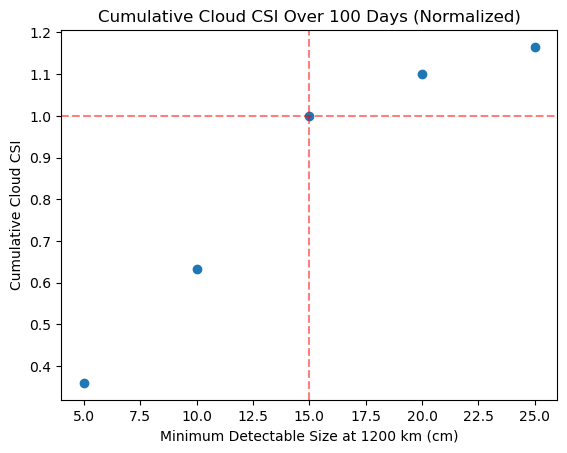

In [103]:
csi_cumulative_list = []
capability_list = []
nube = 'nube_450_km'
for file in os.listdir(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_RADAR/'):
    if file == '.ipynb_checkpoints' or '30' in file:
        continue
    print(file)
    if len(file.split('_')[3]) == 4:
        capability = float(file.split('_')[3][:2])
        print(capability)
    else:
        capability = float(file.split('_')[3][:1])
        print(capability)        
    csi_cumulative = np.loadtxt(f'/Users/luigigisolfi/{str(nube)}/CUMULATIVE_INDEX_RADAR/{file}', unpack = True, usecols = 2)
    csi_cumulative_list.append(csi_cumulative)
    capability_list.append(capability)

print(csi_cumulative_list)
plt.axhline(1, color = 'r', linestyle = '--', alpha = 0.5)
plt.axvline(15, color = 'r', linestyle = '--', alpha = 0.5)
plt.scatter(np.sort(capability_list), np.sort(csi_cumulative_list)/np.sort(csi_cumulative_list)[2])
plt.title('Cumulative Cloud CSI Over 100 Days (Normalized)')
plt.xlabel('Minimum Detectable Size at 1200 km (cm)')
plt.ylabel('Cumulative Cloud CSI')
plt.savefig(f'/Users/luigigisolfi/{str(nube)}/figures/Cumulative_CSI_Radar_{str(nube)}')

[3.05706304 1.75851808 1.         2.78076444 3.24070073]


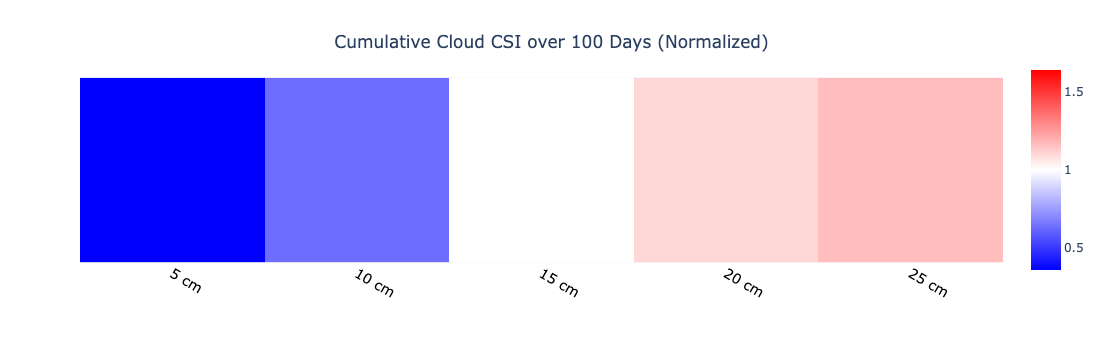

In [105]:
import plotly.express as px

print(csi_cumulative_list/csi_cumulative_list[2])
str_xlabel = [str(round(n)) + ' cm' for n in np.sort(capability_list)]
fig = px.imshow([np.sort(csi_cumulative_list)/np.sort(csi_cumulative_list)[2]], color_continuous_scale=[(0, "blue"), (0.5, "white"), (1, "red")], color_continuous_midpoint=1)
fig.update_xaxes(showticklabels=True).update_yaxes(showticklabels=False)
fig.update_layout(
    title={
        'text': 'Cumulative Cloud CSI over 100 Days (Normalized)',            # Set your desired title text
        'y': 0.9,                           # Vertical position (y-axis) of title (between 0 and 1)
        'x': 0.5,                           # Horizontal position of the title
        'xanchor': 'center',                # Anchor the title text horizontally
        'yanchor': 'top'                    # Anchor the title text vertically
    },
    xaxis=dict(
        tickvals=[0,1, 2, 3, 4,5],              # Positions of the ticks
        ticktext=str_xlabel,  # Custom labels
        tickangle=30,                          # Rotate labels by 45 degrees
        tickfont=dict(size=14, color='black')   # Custom font size and color
    )
)

fig.show()
fig.write_image(f'/Users/luigigisolfi/{str(nube)}/figures/Cumulative_Color_Bar_{str(nube)}.png')